## Part 3: Classification and training models  <hr>

### Date preprocessing and feature extraction
<b>Getting some of the feature extraction and text cleaning again which has been done in Part 1 of the project.

In [28]:
##############################################
# Project Hotel reviews classification
# part 2
# by Saloni Pandya
# NetID: pandyas6
# Dataset visualization
##############################################

import pandas as pd

data = pd.read_csv("Hotel_Reviews.csv")

for column in reviews.columns:
    print(column)

reviews = data[['Hotel_Name', 'Positive_Review', 'Negative_Review', 'Average_Score', 'Reviewer_Score']].copy()
#Concatenating the positve and negative reviews of customers
reviews['review'] = reviews[['Positive_Review', 'Negative_Review']].apply(lambda x: ' '.join(x), axis = 1)

# create the label
reviews["bad_review"] = reviews["Reviewer_Score"].apply(lambda x: 1 if x < 5 else 0)
# select only relevant columns
reviews = reviews[["review", "bad_review"]]

reviews = reviews.sample(frac = 0.1, replace = False, random_state=123)

reviews["review"] = reviews["review"].apply(lambda x: x.replace("No Negative", "").replace("No Positive", ""))

reviews
bad_review


In [12]:
import string
import nltk
nltk.download('averaged_perceptron_tagger')
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import re

def clean_text(text):
    text = re.sub('\t|\r|\n', ' ', text)
    text = re.sub('[A-X]+', lambda m: m.group(0).lower(), text)
    text = text.replace('\r\n',' ').replace('\n',' ').replace('\r',' ')
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    text = [word for word in text if not any(c.isdigit() for c in word)]
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    text = [t for t in text if len(t) > 0]
    text = [t for t in text if len(t) > 1]
    return text

reviews["review"] = reviews["review"].apply(lambda x: clean_text(x))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\salon\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [13]:

# Giving the POS tags to words
def get_POS(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def pos_tag_reviews(text):
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_POS(t[1])) for t in pos_tags]
    text = " ".join(text)
    return text

reviews["review_lemmatized"] = reviews["review"].apply(lambda x: pos_tag_reviews(x))

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer1 = TfidfVectorizer(min_df = 50)
tfidf_result = vectorizer1.fit_transform(reviews["review_lemmatized"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = vectorizer1.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = reviews.index
reviews = pd.concat([reviews, tfidf_df], axis=1)

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

label = "bad_review"
ignore_cols = [label, "review", "review_lemmatized"]
features = [c for c in reviews.columns if c not in ignore_cols]

#-------------------------------------------------------
# Split the data into training (80%) and testing (20%) sets
#-------------------------------------------------------

X_train, X_test, y_train, y_test = train_test_split (reviews[features], reviews[label], test_size = 0.20, random_state = 123)


In [16]:
from sklearn.ensemble import RandomForestClassifier

reviews["bad_review"].value_counts(normalize = True)
rf = RandomForestClassifier(n_estimators = 100, random_state = 123)
rf.fit(X_train, y_train)

# show feature importance
feature_importances_df = pd.DataFrame({"feature": features, "importance": rf.feature_importances_}).sort_values("importance", ascending = False)
feature_importances_df.head(10)

,feature,importance
420,word_dirty,0.017954
1210,word_room,0.017330
115,word_bad,0.014603
833,word_location,0.012260
965,word_nothing,0.011082
1344,word_staff,0.011079
708,word_hotel,0.009939
1215,word_rude,0.009807
1066,word_poor,0.008682
1296,word_small,0.007442


C:\Users\salon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


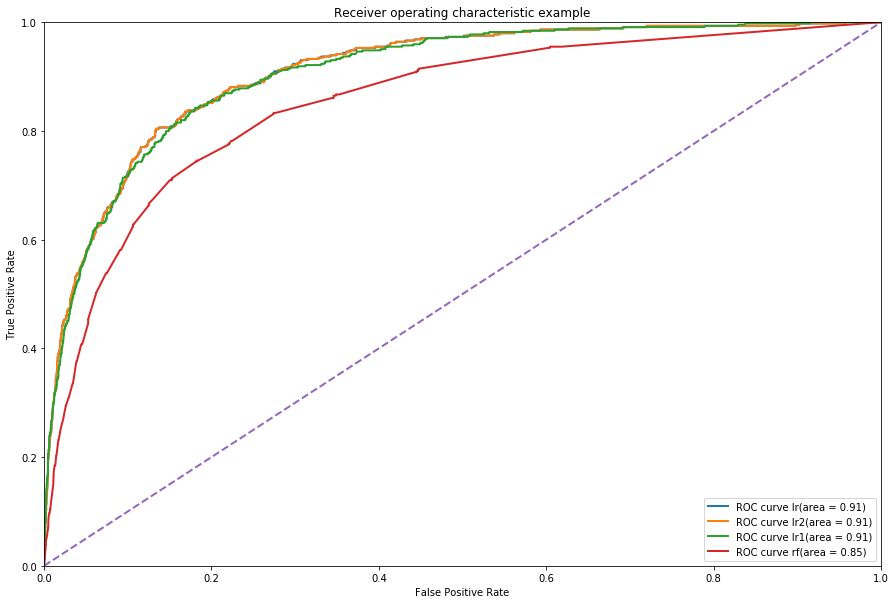

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
import matplotlib.pylab as plt
%matplotlib inline

models = {}

lr  = LogisticRegression()
models['lr']=lr.fit(X_train,y_train)

lrl2     = LogisticRegression(penalty  = 'l2'        , solver = 'newton-cg' )                   # L2 penalty
models['lr2'] = lrl2.fit(X_train,y_train)

lrl1     = LogisticRegression(penalty  = 'l1'        , solver = 'saga' )                   # L1 penalty
models['lr1'] = lrl1.fit(X_train,y_train)

rf = RandomForestClassifier(n_estimators = 100, random_state = 123)
models['rf'] = rf.fit(X_train, y_train)


for i in models.keys():
    
    y_pred = [x[1] for x in models[i].predict_proba(X_test)]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)

    roc_auc = auc(fpr, tpr)

    plt.figure(1, figsize = (15, 10))
    lw = 2
    plt.plot(fpr, tpr,
             lw=lw, label='ROC curve '+ str(i)+'(area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

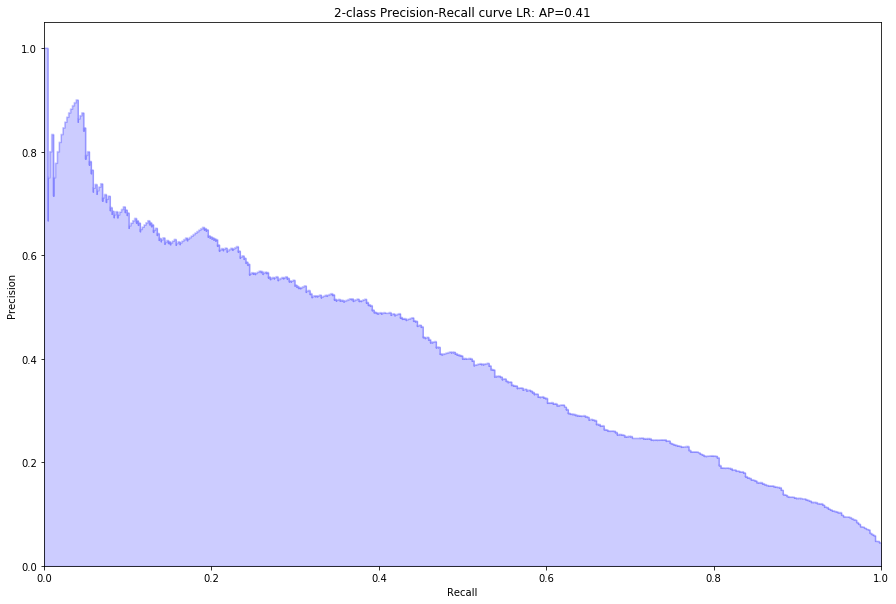

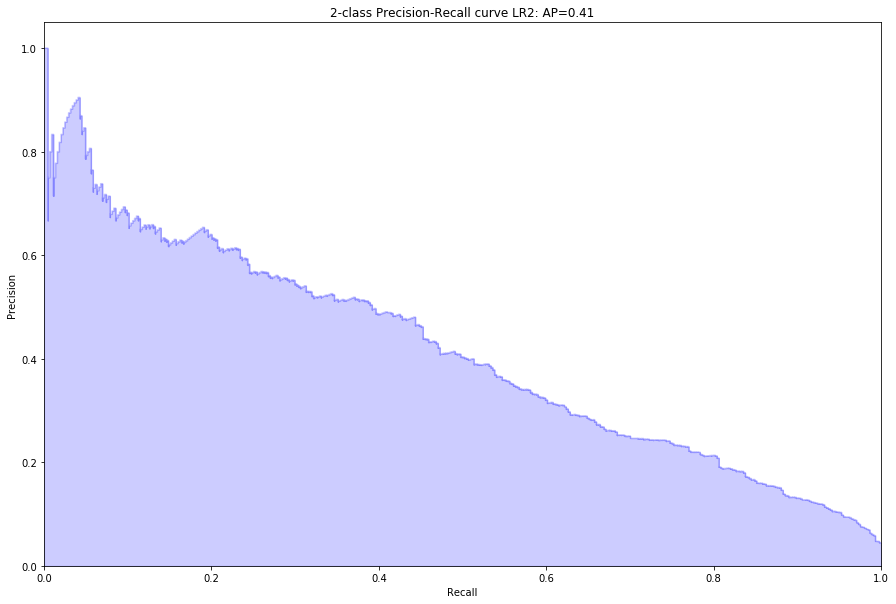

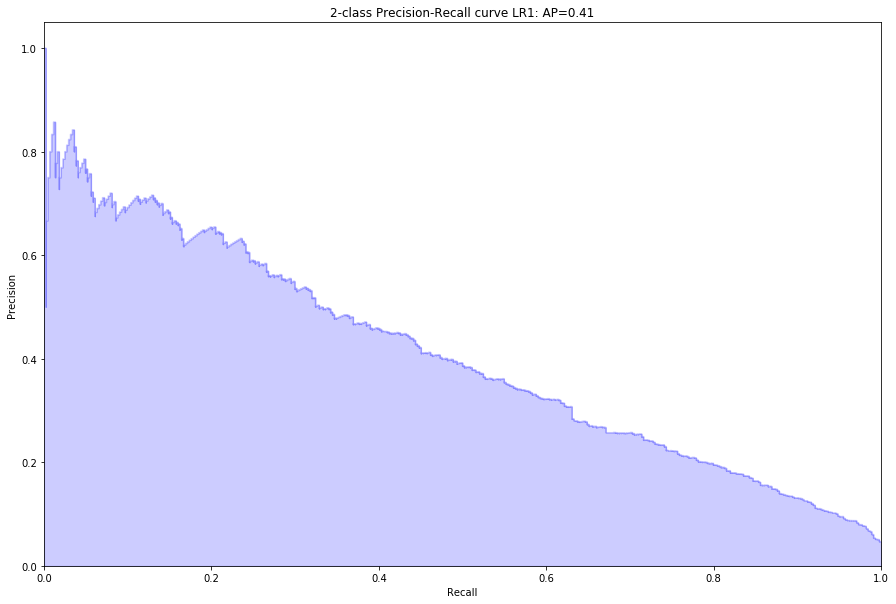

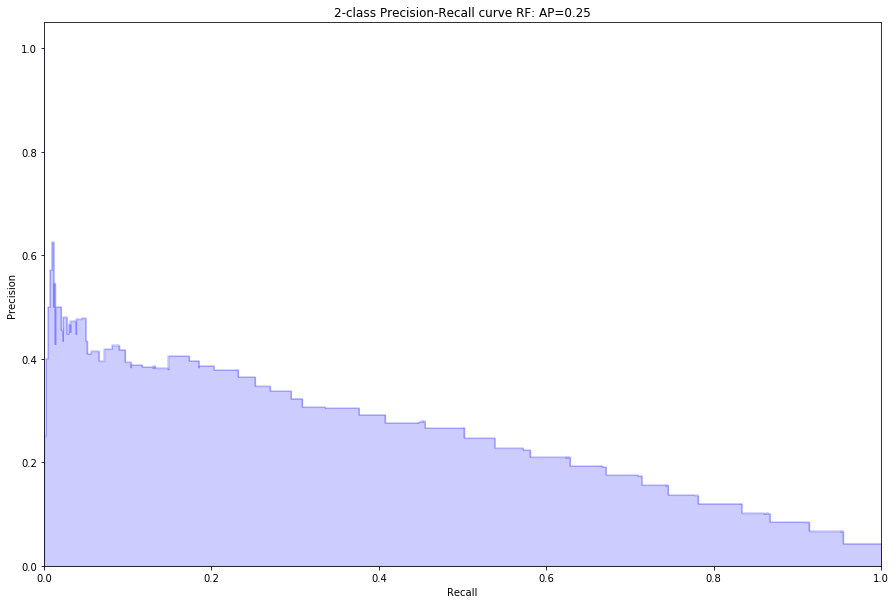

In [18]:
# Percision-Recall curve
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score, precision_recall_curve
from funcsigs import signature


for i in models.keys():
    
    y_pred = [x[1] for x in models[i].predict_proba(X_test)]
    average_precision = average_precision_score(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)

    if 'step' in signature(plt.fill_between).parameters:
        step_kwargs = {'step': 'post'}
    else:
        step_kwargs = {}
    
    plt.figure(1, figsize = (15, 10))
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    plt.title('2-class Precision-Recall curve ' + str(i).upper() +': AP={0:0.2f}'.format(average_precision))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.show()
    

In [22]:
pip install funcsigs

Note: you may need to restart the kernel to use updated packages.


<p><b> As we can observe the characteristics shown by the AUC-ROC curve, the Logistic regression model behaves more accurately and follows the ideal characteristics more accurately than the Random Forest Classifier. Despite this, all the four types of models behave pretty good and give us a result in which the test data follows the training data. The Classification report of all the models trained are shown below. The results show that we can pretty accurately measure the fame of the hotel using the sentiment analysis method to process the customer reviews.</b></p>

In [19]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

for i in models.keys():
    
    prediction = [x for x in models[i].predict(X_test)]
    accuracy = accuracy_score(y_test, prediction)
    print("The accuracy for Model",str(i).upper(),"is", accuracy*100, "% and its Classification Report is as follows:")
    print(classification_report(y_test,prediction))


The accuracy for Model LR is 95.9476490547746 % and its Classification Report is as follows:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      9871
           1       0.66      0.12      0.21       444

    accuracy                           0.96     10315
   macro avg       0.81      0.56      0.59     10315
weighted avg       0.95      0.96      0.95     10315

The accuracy for Model LR2 is 95.9476490547746 % and its Classification Report is as follows:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      9871
           1       0.66      0.12      0.21       444

    accuracy                           0.96     10315
   macro avg       0.81      0.56      0.59     10315
weighted avg       0.95      0.96      0.95     10315

The accuracy for Model LR1 is 96.0155113911779 % and its Classification Report is as follows:
              precision    recall  f1-score   support

          

### A small segment of code finding the best hotels to invest into based on the positive and negative reviews


<b>The below method segregates the reviews into positive and negative and counts theie values to find a total count. The 'famous' hotels are considered as the ones which have the most positive ratings. Sorting the results obtained gives us the top 10 hotels based on the customer ratings in the end. 

In [41]:
data["pos_count"] = 1
data["neg_count"] = 1
data["pos_count"] = data.apply(lambda x: 0 if x["Positive_Review"] == 'No Positive' else x["pos_count"],axis =1)
data["pos_count"].value_counts()

1    479792
0     35946
Name: pos_count, dtype: int64

This shows that the dataset is highly imbalanced because less than 5% of our reviews are considered as negative ones.

In [42]:
data["neg_count"] = data.apply(lambda x: 0 if x["Negative_Review"] == 'No Negative' else x["neg_count"],axis =1)
data["neg_count"].value_counts()

1    387848
0    127890
Name: neg_count, dtype: int64

In [51]:
reviews = pd.DataFrame(data.groupby(["Hotel_Name"])["pos_count","neg_count"].sum())
reviews["Hotel_Name1"] = reviews.index
reviews["total"] = reviews["pos_count"] + reviews["neg_count"]
data["count"] = 1
count_review = data.groupby("Hotel_Name",as_index=False)["count"].sum()

In [55]:
reviews = pd.merge(reviews,count_review,on = "Hotel_Name",how = "left")
reviews["pos_ratio"] = reviews["pos_count"].astype("float")/reviews["total"].astype("float")
famous_hotels = reviews.sort_values(by = "count",ascending=False).head(100)
print("The top 10 famous hotels that could be good opportunities for the investors are as listed below:")
for i in famous_hotels.sort_values(by = "pos_ratio",ascending=False)["Hotel_Name"].head(10):
    print(i)

The top 10 famous hotels that could be good opportunities for the investors are as listed below:
Hotel Berna
Club Quarters Hotel Lincoln s Inn Fields
Apex Temple Court Hotel
Apex City Of London Hotel
Hotel Esther a
Urban Lodge Hotel
Hilton London Canary Wharf
The Piccadilly London West End
Shangri La Hotel at The Shard London
The Student Hotel Amsterdam City


<b>Thus, top 10 hotels can be computed using this way. The future developments may include classifying the hotels based on their reviews taking into consideration details such as their location on the map. One can also calculate the Norm weight to compute the importance of the words involved in the reviews. 